In [31]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

In [32]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [33]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/3_cami2_marine/')
base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [34]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [35]:
d1 = data.table(expand.grid(tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
motus,marine0


In [36]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [37]:
dim(d2)

[1] 14540     7

In [38]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.007112592
singlem,marine0,phylum,Bray-Curtis distance,0.023611599
singlem,marine0,class,Bray-Curtis distance,0.038535068


[1] 7260    5

In [39]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 560   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.007112592
singlem,marine0,phylum,Bray-Curtis distance,0.023611599
singlem,marine0,class,Bray-Curtis distance,0.038535068
singlem,marine0,order,Bray-Curtis distance,0.066818651
singlem,marine0,family,Bray-Curtis distance,0.076268513
singlem,marine0,genus,Bray-Curtis distance,0.096767431
singlem,marine0,species,Bray-Curtis distance,0.170416411
metaphlan,marine0,kingdom,Bray-Curtis distance,0.015746311
metaphlan,marine0,phylum,Bray-Curtis distance,0.044338514


In [40]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.007112592
singlem,marine0,phylum,Bray-Curtis distance,0.023611599
singlem,marine0,class,Bray-Curtis distance,0.038535068


In [41]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.08044602
metaphlan,0.10004610
sourmash,0.12852413
kraken,0.14017992
metabuli,0.31692957


In [42]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


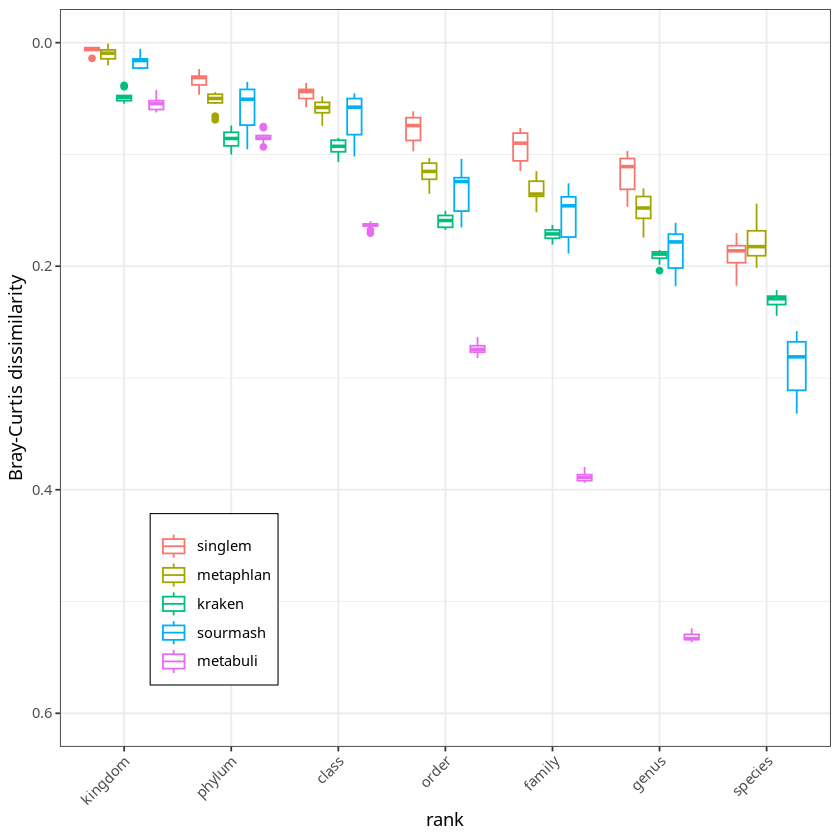

In [43]:

# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

In [67]:
(977-41)/977

[1] 0.9580348

In [44]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
metabuli,0.7220491
sourmash,0.2885927
kraken,0.2314495
singlem,0.1900224
metaphlan,0.1789789


[1] 0.01104349

In [45]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [46]:
# thread_numbers = as.character(c(1,8,32))
thread_numbers = as.character(c(1))

In [47]:
# DEBUG - set to 32 threads so to get a preliminary answer
thread_numbers = c(32)

In [48]:
r1 = data.table(expand.grid(tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<dbl>,<fct>
singlem,32,marine0
metaphlan,32,marine0
motus,32,marine0


In [49]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/3_cami2_marine"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,32,marine0,371.3422,0:06:11,2706.12,37483.21,2655.73,2665.37,262.00,1503.60,713.23,23.93
metaphlan,32,marine0,457.4908,0:07:37,18254.49,57095.98,18229.19,18237.64,16832.86,4558.85,2050.90,73.42
motus,32,marine0,397.9520,0:06:37,8057.16,19005.64,8050.96,8051.13,3193.39,0.01,2457.60,70.58


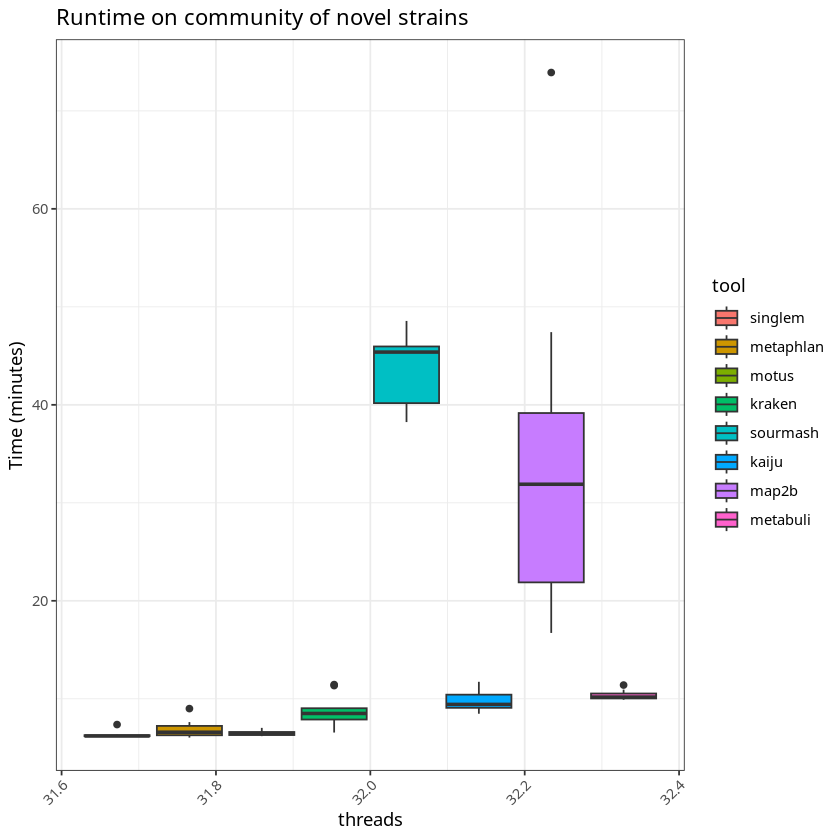

In [50]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


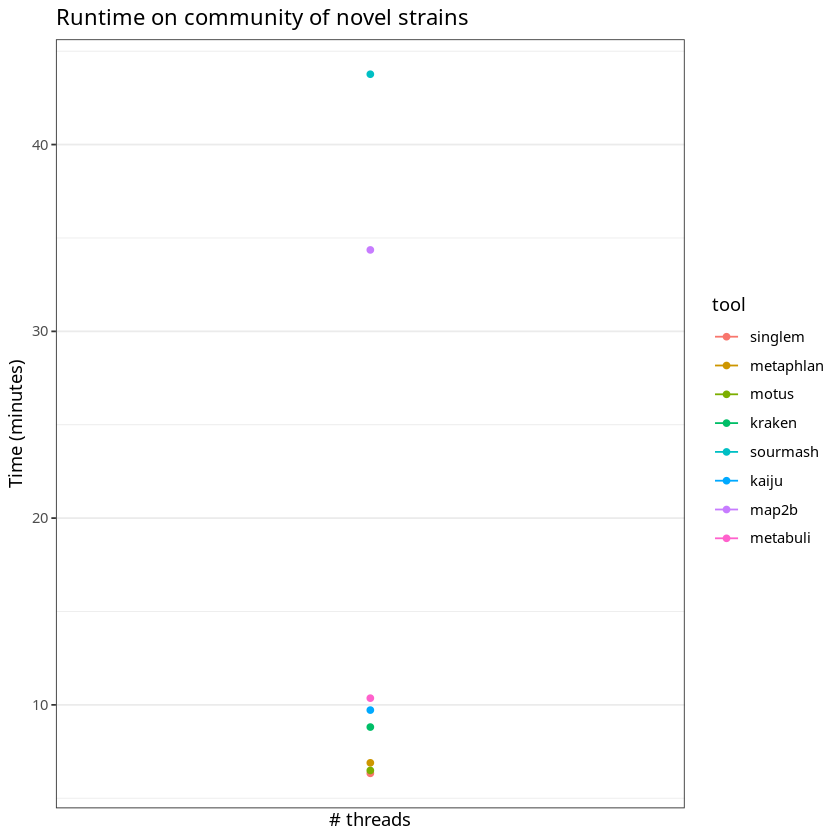

In [51]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


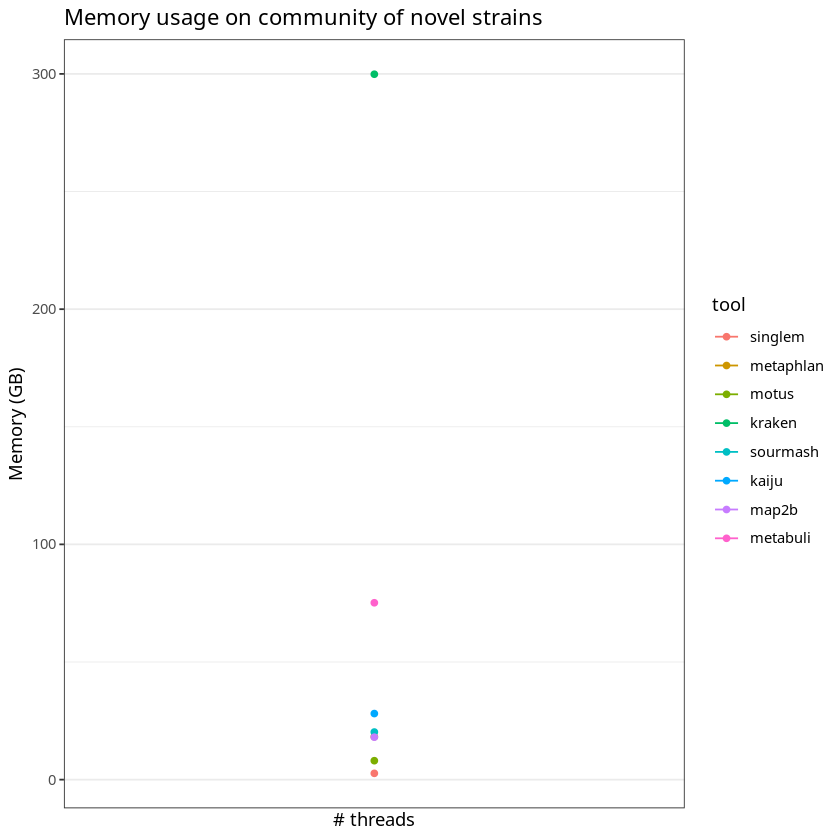

In [52]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [53]:
r4

tool,threads,mean_mem
<fct>,<dbl>,<dbl>
singlem,32,2668.608
metaphlan,32,18238.924
motus,32,8045.054
kraken,32,299869.317
sourmash,32,20230.914
kaiju,32,28080.918
map2b,32,18044.253
metabuli,32,75180.503


In [54]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [55]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')

# Full set of stats of each method

In [56]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1 = s1[tool %in% correct_taxonomy_tools]
s1[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
s1[1:3]
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SingleM,kingdom,0.006353048,1,1,0,0,1,0.01270610,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
MetaPhlAn,kingdom,0.010175557,1,1,0,0,1,0.02035111,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
Kraken2,kingdom,0.048045455,1,1,0,0,1,0.09609091,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN


# Relationship between relative abundance and accuracy

In [57]:
base = base_dir #'/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains/full_run1/checkout/1_novel_strains/'
# base = './'

truth_profiles = data.table(community=communities)
truth_profiles2 = truth_profiles[, fread(paste(base,'/truths/',community,'.condensed',sep='')), by=community]
truth_profiles2[, sample := NULL]
setnames(truth_profiles2, 'coverage', 'true_coverage')

tool_profiles = data.table(expand.grid(tools, communities))
setnames(tool_profiles, c('tool','community'))
tool_profiles2 = tool_profiles[, fread(paste(base,'/output_',tool,'/',tool,'/',community,'.profile',sep='')), by=list(tool,community)]
tool_profiles2[, sample := NULL]
setnames(tool_profiles2, 'coverage', 'tool_coverage')
tool_profiles2[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3 = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 's__']
)
tool_profiles3[tool=='kraken'][1:5]
# cartesian product so the all = T works for each tool
community_tool = data.table(expand.grid(tools, communities))
setnames(community_tool, c('tool','community'))
truth_profiles3 = merge(truth_profiles2, community_tool, all=T, allow.cartesian=T)
# truth_profiles3

m = merge(truth_profiles3, tool_profiles3, by=c('taxonomy','community','tool'), all=T)

m[is.na(tool_coverage), tool_coverage := 0]
m[is.na(true_coverage), true_coverage := 0]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.02133,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio splendidus
kraken,marine0,0.02120,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio ordalii
kraken,marine0,0.00997,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio natriegens
kraken,marine0,0.00660,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio coralliilyticus
kraken,marine0,0.00541,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio;s__Vibrio nigripulchritudo


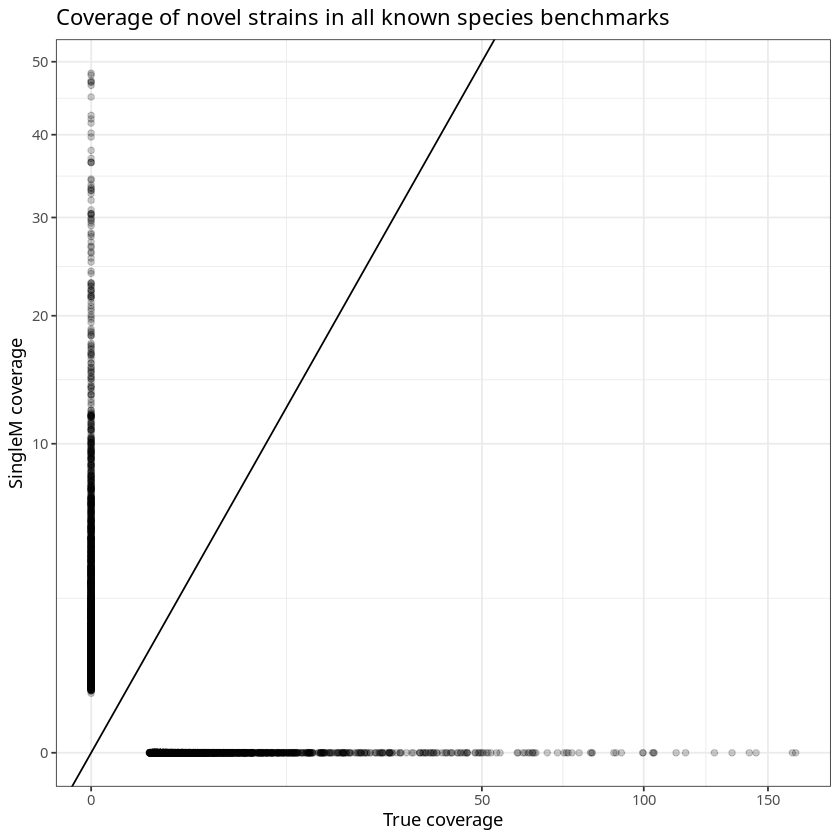

In [58]:
# Just for SingleM
qplot(data=m[tool=='singlem' & tool_coverage < 50][grep('s__',taxonomy)], true_coverage, tool_coverage, geom='point', xlab='True coverage', ylab='SingleM coverage', main='Coverage of novel strains in all known species benchmarks', alpha=I(1/5)) + geom_abline(intercept=0, slope=1)+scale_x_sqrt()+scale_y_sqrt()

In [59]:
m[tool=='kraken'][grep('s__',taxonomy)][community=='marine6'][order(-tool_coverage)][1:3]

taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Bacteria;p__Desulfobacterota;c__Desulfuromonadia;o__Desulfuromonadales;f__Syntrophotaleaceae;g__Syntrophotalea;s__Syntrophotalea acetylenica,marine6,kraken,0,0.04932
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Nitrococcales;f__Nitrococcaceae;g__Spiribacter;s__Spiribacter curvatus,marine6,kraken,0,0.04772
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Alteromonadaceae;g__Alteromonas;s__Alteromonas mediterranea,marine6,kraken,0,0.03506


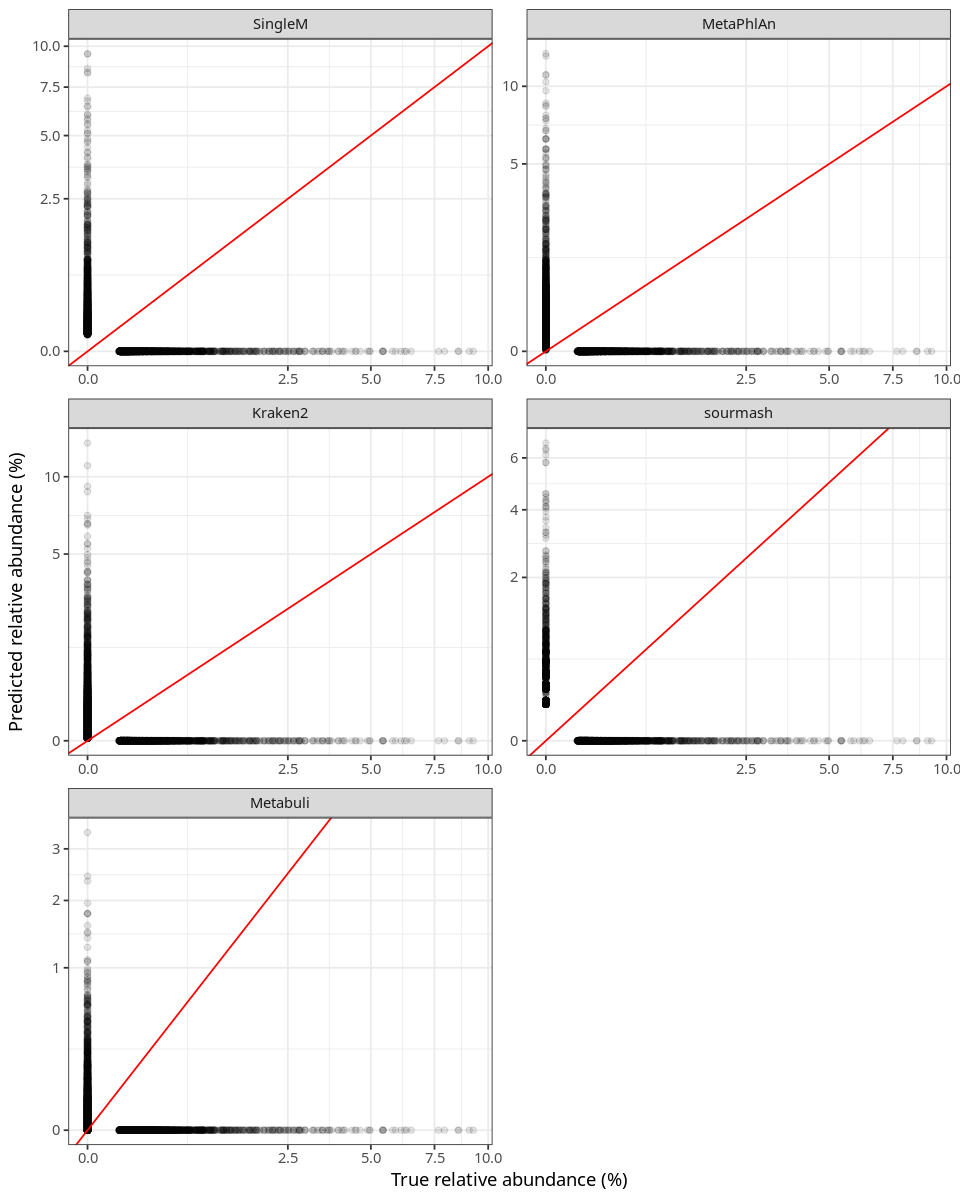

In [60]:
# All tools
# First convert to relabund
m[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m = m[tool %in% correct_taxonomy_tools]
m[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m[grep('s__',taxonomy)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [61]:
# What's with the 20+ coverage genome?

# marine0 = fread(paste(base,'truths/marine0.condensed',sep=''))
# marine0[, sample := 'marine0']
# setnames(marine0, 'coverage', 'true_coverage')
# singlem_marine0 = fread(paste(base,'output_singlem/singlem/marine0.profile',sep=''))
# setnames(singlem_marine0, 'coverage', 'singlem_coverage')
# singlem_marine0[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]
# # singlem_marine0[grep('s__',taxonomy)][1:3]

# m[true_coverage > 20 & singlem_coverage ==0]
# singlem_marine0[grep('g__Pseudomonas_E',taxonomy)]
# # => So it backed off to species level for some reason. Unsure why.

In [62]:
# Fraction of genomes which were missed at each binned coverage levels
# m[, .(missed = sum(singlem_coverage==0)/.N*100, .N), by=.(cut(true_coverage, breaks=c(0,2,4,6,8,10,20,40,1000)))][order(cut)]

In [63]:
# How well does genus level rescue some of the missing genomes? First need to remake the table with genus level, annoying since kraken profiles are filled, when the rest aren't.

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3_genus = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 'g__']
)
tool_profiles3_genus[tool=='kraken'][1:5]

m_genus = merge(truth_profiles3, tool_profiles3_genus, by=c('taxonomy','community','tool'), all=T)

m_genus[is.na(tool_coverage), tool_coverage := 0]
m_genus[is.na(true_coverage), true_coverage := 0]

m_genus[1:3]

m_genus[, genus_and_up := gsub(';s__.*','',taxonomy)]

# m[grep('g__',taxonomy)][1:10]
m2_genus = m_genus[, .(tool_coverage=sum(tool_coverage), true_coverage=sum(true_coverage)), by=.(community, genus_and_up, tool)]

m2_genus[grep('g__',genus_and_up)][tool=='kraken' & true_coverage > 0][1:3]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.11946,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Vibrio
kraken,marine0,0.04271,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Aliivibrio
kraken,marine0,0.00392,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Photobacterium
kraken,marine0,0.00005,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Enterovibrio
kraken,marine0,0.00002,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Vibrionaceae;g__Salinivibrio


taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus;s__Archaeoglobus fulgidus,marine0,singlem,7.85432,0
Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus;s__Archaeoglobus fulgidus,marine0,metaphlan,7.85432,0
Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus;s__Archaeoglobus fulgidus,marine0,motus,7.85432,0


community,genus_and_up,tool,tool_coverage,true_coverage
<fct>,<chr>,<fct>,<dbl>,<dbl>
marine0,Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus,kraken,0,7.85432
marine1,Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus,kraken,0,5.14468
marine2,Root;d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__Archaeoglobaceae;g__Archaeoglobus,kraken,0,6.06893


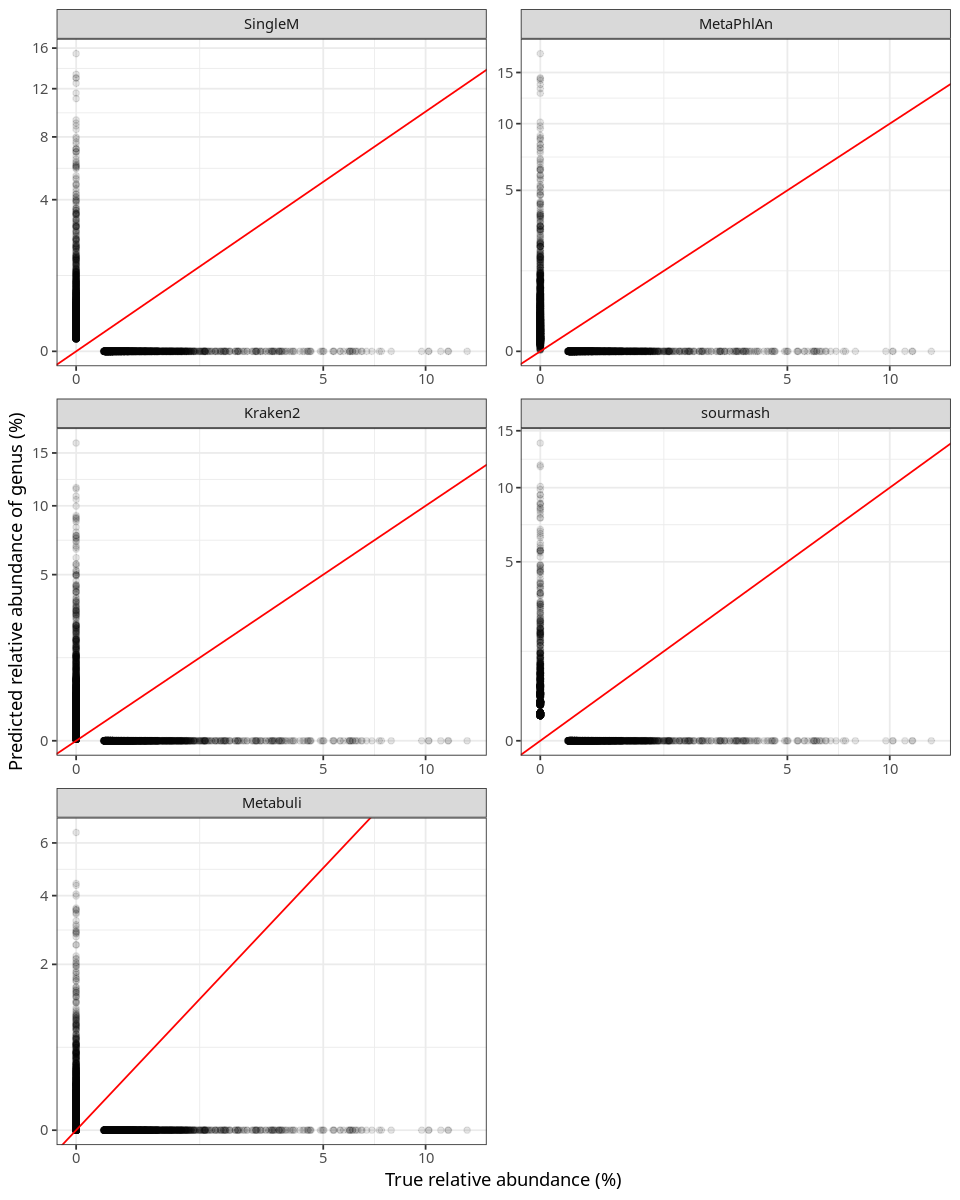

In [64]:
m2_genus[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m2_genus[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m2_genus = m2_genus[tool %in% correct_taxonomy_tools]
m2_genus[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m2_genus[grep('g__',genus_and_up)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance of genus (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [65]:
# Percent error at the species level for each tool
m_error = m[true_coverage>0 & tool_coverage>0]
m_error[, error := abs(true_coverage_relabund - tool_coverage_relabund)/true_coverage_relabund*100]

qplot(data=m_error, true_coverage, error, geom='point', xlab='True coverage', ylab='Percent error (%)', alpha=I(1/10))+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')+geom_smooth(se=F)

ERROR while rich displaying an object: Error in `combine_vars()`:
! Faceting variables must have at least one value

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. pas

# What fraction of singlem profiles are assigned to the species level?

In [66]:
# m
assigned = m[tool2=='SingleM'][,sum(.SD[grep('s__',taxonomy)]$tool_coverage_relabund),by=community]
assigned
mean(assigned$V1)
sd(assigned$V1)

community,V1
<fct>,<dbl>
marine0,70.42568
marine1,69.04435
marine2,69.24487
marine3,68.51401
marine4,67.67208
marine5,70.79817
marine6,68.21606
marine7,69.61405
marine8,69.12832


[1] 69.00157

[1] 1.107107